In [25]:
# !rm -rf data

# KMNIST as example

# Download the KMNIST dataset from torchvision

import torchvision
from torchvision.transforms import transforms

# Do some transformation when we download the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))])

# Download the both the training and testing dataset
train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Print out the downloaded data
print(train_dataset)
print(val_dataset)

import torch

batch_size = 16

# Create dataloader for both training and testing data
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
Dataset KMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


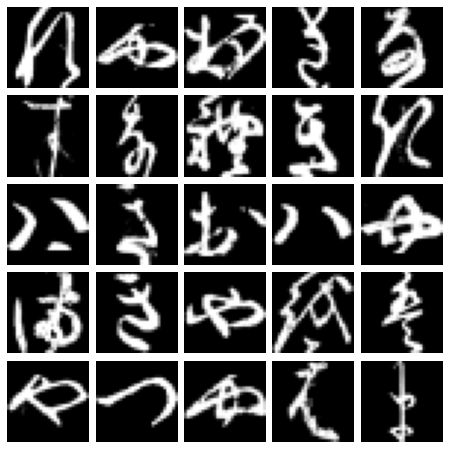

In [26]:
# Examine the KMNIST dataset

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(
    fig, 111,  # Similar to subplot(111)
    nrows_ncols=(5, 5),  # Create 5 by 5 grid of axes
    axes_pad=0.1,  # Pad between axes in inch.
)

# Iterating over the grid returns the Axes.
for ax, (x, y) in zip(grid, train_dataset):
    # Unmornalize
    x = x / 2 + 0.5 
    # To numpy
    x = x.numpy()
    # Squeeze the image since there is only one channel
    x = x.squeeze()
    ax.imshow(x, cmap='gray')
    ax.set_axis_off()

plt.show()

In [27]:
# Define the structure of your network

# For building neural networks
import torch.nn as nn

# For optimizers
import torch.optim as optim

# For activation functions
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.conv2 = nn.Conv2d(12, 24, 5)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(24*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [28]:
# GPU configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torchmetrics

# metric = torchmetrics.Accuracy()

def train_one_step(model, data, loss_func, optimizer):
    global device
    # Data
    x, y = data
    x, y = x.to(device), y.to(device)
    # Forward pass
    y_pred = model(x)
    loss = loss_func(y_pred, y)
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    # Optimize
    optimizer.step()

    correct = (y_pred.argmax(1) == y).type(torch.float).sum().item()
    loss = loss.cpu().item()
    
    return correct, loss

def train_one_epoch(model, dataloader, loss_func, optimizer):
    model.train()

    n_data = len(dataloader.dataset)
    n_batch = len(dataloader)

    total_loss = 0
    total_correct = 0
    
    for batch_idx, data in enumerate(dataloader):
        correct, loss = train_one_step(model, data, loss_func, optimizer)
        total_correct += correct
        total_loss += loss
    
    avg_loss = total_loss / n_batch
    acc = total_correct / n_data
    return acc, avg_loss

def val_one_step(model, data, loss_func):
    # Data
    x, y = data
    x, y = x.to(device), y.to(device)
    # Forward pass
    y_pred = model(x)
    loss = loss_func(y_pred, y)
    
    correct = (y_pred.argmax(1) == y).type(torch.float).sum().item()
    loss = loss.cpu().item()
    
    return correct, loss

def val_one_epoch(model, dataloader, loss_func):
    model.eval()

    n_data = len(dataloader.dataset)
    n_batch = len(dataloader)

    total_loss = 0
    total_correct = 0
    
    for batch_idx, data in enumerate(dataloader):
        with torch.no_grad():
            correct, loss = val_one_step(model, data, loss_func)
        total_correct += correct
        total_loss += loss
    
    avg_loss = total_loss / n_batch
    acc = total_correct / n_data
    return acc, avg_loss

def summary(epoch, n_epoch, train_acc, train_loss, val_acc, val_loss):
    print(f'Epoch [{epoch+1}/{n_epoch}] TrainAcc [{train_acc:.2%}] ValAcc [{val_acc:.2%}] TrainLoss [{train_loss:.2f}] ValLoss [{val_loss:.2f}]')

In [42]:
class Statistics:
    def __init__(self):
        self.train_acc_list = []
        self.val_acc_list = []
        self.train_loss_list = []
        self.val_loss_list = []
    def log_train_acc(self, acc):
        self.train_acc_list.append(acc)
    def log_val_acc(self, acc):
        self.val_acc_list.append(acc)
    def log_train_loss(self, loss):
        self.train_loss_list.append(loss)
    def log_val_loss(self, loss):
        self.val_loss_list.append(loss)
    def log(self, train_acc, train_loss, val_acc, val_loss):
        self.log_train_acc(train_acc)
        self.log_val_acc(val_acc)
        self.log_train_loss(train_loss)
        self.log_val_loss(val_loss)
    def plot(self):
        plt.subplot(221)
        plt.plot(stat.train_acc_list)
        plt.plot(stat.val_acc_list)

        plt.subplot(222)
        plt.plot(stat.train_loss_list)
        plt.plot(stat.val_loss_list)
        
        plt.show()

In [44]:
# Create our model
model = ConvNet()

# We can also print the strcuture of our neural network by using "print(model)"

# Push the model to GPU
model.to(device)

# Loss function
loss_func = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

# n_epoch = 5
n_epoch = 2

print('=== Started Training ===')

stat = Statistics()

for epoch in range(n_epoch):

    train_acc, train_loss = train_one_epoch(model, train_dataloader, loss_func, optimizer)
 
    val_acc, val_loss = val_one_epoch(model, val_dataloader, loss_func)
 
    stat.log(train_acc, train_loss, val_acc, val_loss)

    summary(epoch, n_epoch, train_acc, train_loss, val_acc, val_loss)

print('=== Finished Training ===')

=== Started Training ===
Epoch [1/2] TrainAcc [22.96%] ValAcc [26.61%] TrainLoss [2.28] ValLoss [2.25]
Epoch [2/2] TrainAcc [54.83%] ValAcc [50.59%] TrainLoss [1.68] ValLoss [1.53]
=== Finished Training ===


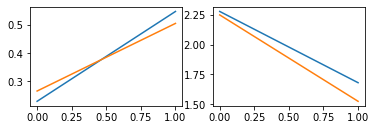

In [45]:
stat.plot()

In [46]:
save_path = 'ckpt/kmnist-cnn.pth'

# Save model
torch.save(model.state_dict(), save_path)

# Load model
ckpt = torch.load(save_path)
model.load_state_dict(ckpt)

<All keys matched successfully>